# Super-resolution resampling methods 

Following on from our meeting, a brief test to see which super-resolution resampling method works best, and whether there is much of a difference.

In summary, there doesn't seem to be a big difference, and it seems that regtricks is in fact doing this the other way round compared to applywarp, but I would nevertheless like to leave things as they are (for pragmatic code-related reasons explained later). 

In [1]:
%load_ext autoreload
%autoreload 2
import regtricks as rt 
import matplotlib.pyplot as plt
import numpy as np 
import nibabel 
from pdb import set_trace
from scipy.spatial.transform import Rotation
from pvec_functions import * 

## Test setup

The experiment uses a spherical test phantom, as shown previously, for which we can easily calculate PVs in after any transformation via a numerical method. The test is as follows: 
1. Define a T1 space at 0.75mm resolution, and estimate PVs in it 
2. Define an ASL space at 3mm resolution, 4x coarser than T1.  
3. Define a translation in the xy plane, and calculate PVs in the ASL space *after* the translation. This is the ground truth for (4) and (5). 
4. Resample and transform the T1 PV estimates from (1) to the ASL grid using supersampling on the source voxel grid (ie, T1)
5. Resample and transform the T1 PV estimates from (1) to the ASL grid using supersampling on the reference voxel grid (ie, ASL)

In [2]:
asl_spc = rt.ImageSpace.create_axis_aligned([0,0,0], [60,60,1], [3,3,3])
sph_cent = asl_spc.fov_size[:2] / 2
t1_factor = 4
t1_spc = asl_spc.resize_voxels(np.array([1/t1_factor, 1/t1_factor, 1]))

In [3]:
R_g = 80
R_w = 75

In [4]:
pvs_t1 = calc_sphere_pvs(sph_cent, R_g, R_w, t1_spc, 10)

In [5]:
shift = np.array([1.7,4.3])
transform = np.eye(4)
transform[:2,3] = shift
transform = rt.Registration(transform)
transform

Registration (linear) with properties:
src2ref:       [   1.000    0.000    0.000    1.700]
               [   0.000    1.000    0.000    4.300]
               [   0.000    0.000    1.000    0.000]
               [   0.000    0.000    0.000    1.000]

In [6]:
pv_trans_true = calc_sphere_pvs(sph_cent + shift, R_g, R_w, asl_spc, 25)

## Super-sampling the source image 

For this approach, we upsample the source image (*increasing* the resolution disparity between source and reference even further; the source is already finer than the reference), apply the forward transformation to push the super-resolution source voxels into the reference space, and then average across the larger voxels of the reference grid. 

This requires us to go off-piste a bit with regards to implementation: in particular, it is harder to deal with FoV issues, whereby sorce voxels are pushed outside the FoV of the reference voxel grid, and a bit harder to ensure we are correctly averaging across the appropriate voxel neighbourhoods when downsampling to target resolution (particularly on edges). 

Note that the source is already 4x higher resolution than the reference, so with the supersampling of 3x used here, it becomes 12x higher. 

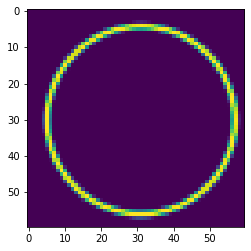

In [7]:
super_src = super_source_resample(pvs_t1[...,0], transform, t1_spc, asl_spc, [3,3,1])
plt.imshow(super_src)

## Super-sampling the reference image 

For this approach, we upsample the reference image (*decreasing* the resolution disparity between source and reference; making the reference closer in resolution to the source) and apply the inverse transformation to pull the super-resolution reference voxels into the source voxel grid. We then interpolate within the source grid to get the super-resolution output, and finally average across neighbourhoods to get the low resolution output. 

The advantages of this is that we can use image interpolation functions from SciPy (much safer than my code) which provide a multitude of ways of handing FoV issues, order of interpolation, pre-filtering etc etc. It's a much more robust way of doing things. Furthermore, the process of averaging across neighbourhoods is also much safer (because FoV issues are handled gracefully, whereas the super-sampled source method requires more careful checking). 

With the supersampling factor of 3x used here, the super-resolution reference grid becomes 1mm isotropic, vs a source resolution of 0.75mm isotropic. Note that the regtricks default for supersampling is to try and match the source/ref voxel grids, which in this case would be 4x. 

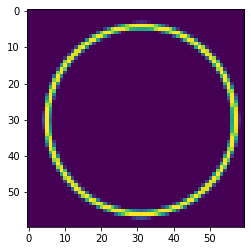

In [8]:
super_ref = super_ref_resample(pvs_t1[...,0], transform, t1_spc, asl_spc, [3,3,1])
plt.imshow(super_ref)

## Regtricks default settings

Default supersampling settings of ratio of voxel size. 

In [9]:
rt_def = transform.apply_to_array(pvs_t1[...,0], t1_spc, asl_spc)

## Comparison

Both methods were run with 3x supersampling, but this doesn't really mean they are running 'at the same settings'. As can be seen below, the same supersampling factor doesn't imply the same underlying ratio of resolutions for the interpolation operation. 
- For the super-sampled source approach, the ratio of input / output resolution is 12:1
- For the super-sampled reference approach, the ratio of input / output resolution is 4:3 

We measure errors within a GM mask wrt the numerical ground truth and take the mean absolute difference. Both methods perform similarly, to within ~0.005% absolute voxel PV difference. 

In summary, these results show that the question of which approach to use is of negligible importance, and I would therefore prefer to keep regtricks using the super-sampled reference approach: it uses tried and tested code from SciPy which is safer and more adaptable to other use cases. 

In [10]:
mask = (pv_trans_true[...,0] > 0)
super_src_error = np.abs(pv_trans_true[...,0] - super_src)[mask]
super_ref_error = np.abs(pv_trans_true[...,0] - super_ref)[mask]
rt_def_error = np.abs(pv_trans_true[...,0] - rt_def)[mask]

In [11]:
print('Super source:', super_src_error.mean())
print('Super ref:', super_ref_error.mean())
print('RT def:', rt_def_error.mean())

Super source: 0.013749136736385396
Super ref: 0.011165337487100031
RT def: 0.010872740546981417


## Order of interpolation

SciPy's default order of spline interpolation is 3. Use the simulation to measure errors across the range of possible values of 1-5. 3 is the best performing case. 

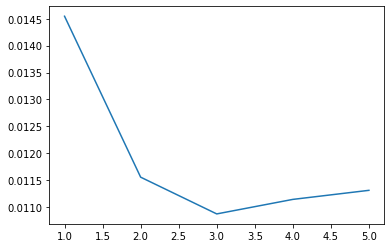

In [12]:
orders = np.arange(1,6)
errors = np.zeros(orders.size)
for o in orders:
    t = transform.apply_to_array(pvs_t1[...,0], t1_spc, asl_spc, order=o)
    err = np.abs(pv_trans_true[...,0] - t)
    errors[o-1] = err[mask].mean()
    
plt.plot(orders, errors)